Boiler Plate

In [1]:
import matplotlib.pyplot as plt;
import numpy as np;
import scipy.optimize as opt;
from scipy.stats import norm


In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## OK lets assume we have a background model and we want to determine a systematic.

  * For simplicity assume the model is a straight line through the origin with unit slope
  * We also assume we have some kind of control region where we can test our model
  * Again, for simplicity, we will assume that our model is "correct" (ie: observed data comes from sampling the model)

_Setup_

In [3]:
nPoints = 51
x_min = -25
x_max = 25
y_err = 2.5

def bkgModel(x,m=1,b=0):
    return m*x+b



In [4]:
nPoints = 51
x_min = -25
x_max = 25
y_err = 0.5


Nominal Background model with no systematics

In [5]:
def nominalBkgModel(x,m=1,b=0):
    return m*x+b

Generate data according to the model
  * Assume the data is drawn from the baground 
  * Incluse fractional random (gaussian) errors  

In [6]:
def getData(sigmaY=0.1,m=1,b=0):
    xs = np.linspace(x_min,x_max,nPoints)
    #ys = bkgModel(xs,m,b) + np.random.normal(0,sigmaY,len(xs))*bkgModel(xs)
    ys = bkgModel(xs,m,b) + np.random.normal(0,sigmaY,len(xs))
    eys = np.full(len(xs),sigmaY)
    return xs,ys,eys

Generate some data for our control region

In [7]:
CR_data_x, CR_data_y, CR_errors_y = getData(sigmaY=y_err)

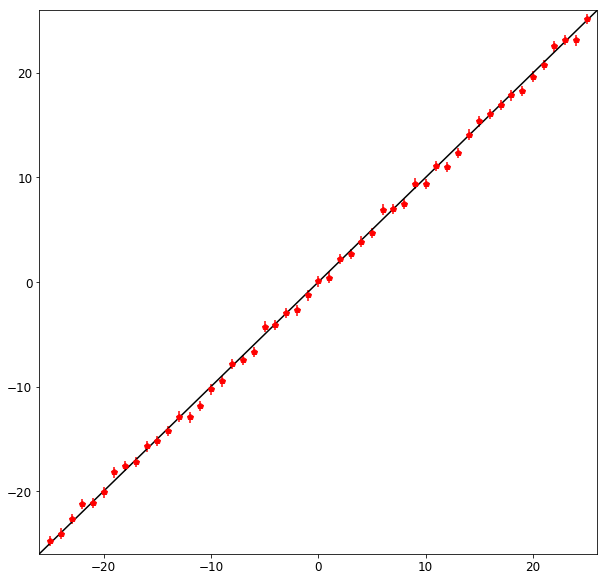

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((x_min-1, x_max+1))
ax.set_ylim((x_min-1, x_max+1))
plt.errorbar(CR_data_x,CR_data_y,yerr=CR_errors_y,color="r",ls='',marker="p")

x = np.linspace(x_min-1, x_max+1,100)
plt.plot(x,bkgModel(x),"k")

OK, so we have control region with which to test our model.

See good agreement and now want to use the quantitative CR agreement to extract a systematic in the signal region

## Method 1: Taking residuals as systematic
  * In this first method we simply take the differece between the observed CR data and the model as the systematic
  * so the +1 sigma systematic variation would be nomimal model plus the residuals
  * and the -1 sigma would be nominal model minus the residuals

In [9]:
CR_residuals = CR_data_y - bkgModel(CR_data_x)

Heres what they look like:

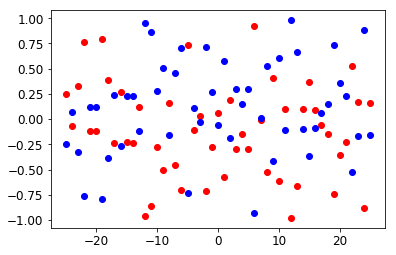

In [10]:
plt.plot(CR_data_x,1*CR_residuals,"ro")
plt.plot(CR_data_x,-1*CR_residuals,"bo")

From this we can construct our full bacground model, which now depends on a systematic nuisance paramater controling how much systematic variation is present

In [11]:
def bkgModelFull_v1(x,p0):
    return bkgModel(x)+p0*CR_residuals

Now lets apply this model to toy data in our signal region, assumeing background only

In [12]:
SR_data_x, SR_data_y, SR_errors_y = getData(sigmaY=y_err)

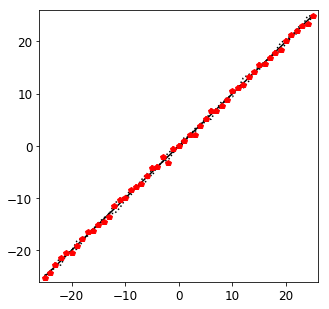

In [13]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_xlim((x_min-1, x_max+1))
ax.set_ylim((x_min-1, x_max+1))
plt.errorbar(SR_data_x,SR_data_y,yerr=SR_errors_y,color="r",ls='',marker="p")

x = np.linspace(x_min-1, x_max+1,100)
#plt.plot(x,trueYvsX(x),"k:")
plt.plot(SR_data_x,bkgModelFull_v1(SR_data_x,0),"k")
plt.plot(SR_data_x,bkgModelFull_v1(SR_data_x,-1),"k:")
plt.plot(SR_data_x,bkgModelFull_v1(SR_data_x,+1),"k:")


Calculate the SR resdiuals

In [14]:
SR_residuals = SR_data_y - bkgModel(SR_data_x)

Now compare with the +/- 1 sigma systematic band

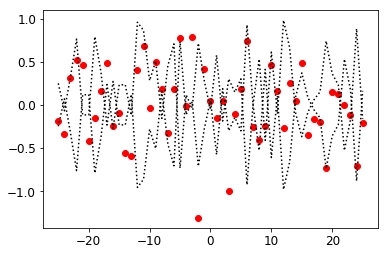

In [15]:
plt.plot(SR_data_x, SR_residuals,"ro")
plt.plot(SR_data_x,1*CR_residuals,"k:")
plt.plot(SR_data_x,-1*CR_residuals,"k:")

Note here, overall scale is correct, *but* relative bin-to-bin fluctions are different in the SR and CR residuals


This is expected as these bin-to-bin differences are the results of random fluctations.

### We can now fit the SR data with our full background model to determine the value of the systematics nuisance  parameter preferred by the signal region

In [16]:
p0 = [0]
fitResults = opt.curve_fit(bkgModelFull_v1, SR_data_x, SR_data_y, sigma=SR_errors_y, p0=p0)

In [17]:
def getFitParamAndError(fitRes,pIndex):
    p_fit = fitRes[0][pIndex]
    p_err = np.sqrt(fitResults[1][pIndex][pIndex])
    return p_fit, p_err

In [18]:
p0_fit, p0_err = getFitParamAndError(fitResults,0)

In [19]:
p0_fit,p0_err

(0.24225414649006324, 0.12752718105393043)

Now do this 10k times and plot the value of the nuisance paramter fit

In [20]:
p0_true = 0 
p0_sigma = 1
p0_pulls = []

for i in range(10000):
    toy_data_x, toy_data_y, toy_errors_y = getData(sigmaY=y_err)
    p0 = [ 0]
    fitResults = opt.curve_fit(bkgModelFull_v1, toy_data_x, toy_data_y, sigma=toy_errors_y, p0=p0)
    p0_fit, p0_err = getFitParamAndError(fitResults,0)

    p0_pull = (p0_fit-p0_true)/p0_sigma
    p0_pulls.append(p0_pull)


Plot the pulls compared with a unit gaussian, expected if the systematics are not overconstrained

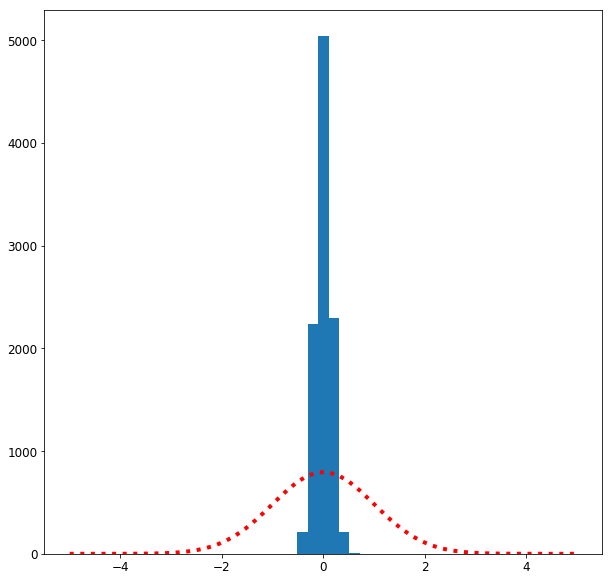

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))


ax.hist(p0_pulls,bins=np.linspace(-5,5,50))
x_axis = np.linspace(-5,5,50)

binWidth = 10/50
ax.plot(x_axis, 10000*binWidth*norm.pdf(x_axis,0,1),"r:",linewidth=4)
plt.show()

In [22]:
def getSysShiftedData_v1(p0,sigmaY=0.1,m=1,b=0):
    xs = np.linspace(x_min,x_max,nPoints)
    #ys = bkgModel(xs,m,b) + np.random.normal(0,sigmaY,len(xs))*bkgModel(xs)
    ys = bkgModelFull_v1(xs,p0) + np.random.normal(0,sigmaY,len(xs))
    eys = np.full(len(xs),sigmaY)
    return xs,ys,eys

In [23]:
p0_true = [] 
p0_sigma = 1
p0_fits = []
p0_pulls = []

for i in range(10000):
    p0_true.append(np.random.normal(0,1))
    toy_data_x, toy_data_y, toy_errors_y = getSysShiftedData_v1(p0_true[-1],sigmaY=y_err)
    p0 = [ 0]
    fitResults = opt.curve_fit(bkgModelFull_v1, toy_data_x, toy_data_y, sigma=toy_errors_y, p0=p0)
    p0_fit, p0_err = getFitParamAndError(fitResults,0)

    p0_fits.append(p0_fit)
    p0_pull = (p0_fit-p0_true[-1])/p0_sigma
    p0_pulls.append(p0_pull)



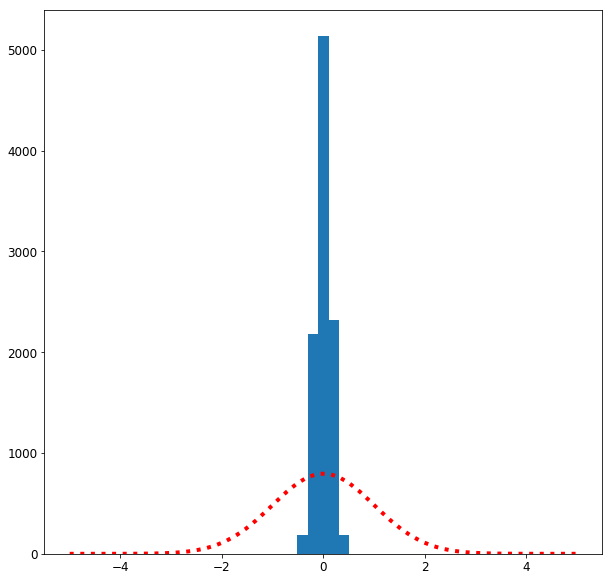

In [24]:
fig, ax = plt.subplots(1, figsize=(10,10))


ax.hist(p0_pulls,bins=np.linspace(-5,5,50))
x_axis = np.linspace(-5,5,50)

binWidth = 10/50
ax.plot(x_axis, 10000*binWidth*norm.pdf(x_axis,0,1),"r:",linewidth=4)
plt.show()

In [41]:
#fig, ax = plt.subplots(1, figsize=(10,10))
#ax.plot(p0_true,p0_fits,"ko")


## Method 2: Fitting smooth fucnction
  * In this second method we fit the CR data with a emprical model to account to determine the deviation from our nominal background model
  * so the +1 sigma systematic variation would be nomimal model plus the residuals
  * and the -1 sigma would be nominal model minus the residuals

Lets fit for systematic differences

In [26]:
def sysFunction(x, p0, p1):
    return p0*x+p1

In [27]:
p0 = [1,0]
fitResults = opt.curve_fit(sysFunction, CR_data_x, CR_data_y, sigma=CR_errors_y, p0=p0)

In [28]:
slope_fit, slope_err = getFitParamAndError(fitResults,0)
offset_fit, offset_err = getFitParamAndError(fitResults,1)

In [29]:
print("systematic slope",slope_fit,"+/-",slope_err)
print("systematic offset",offset_fit,"+/-",offset_err)

systematic slope 0.9950463449235629 +/- 0.004399828193972057
systematic offset -0.10734913108702118 +/- 0.06476370852376348


We see that our model holds in the CR (ie, m=1 are b=0 are consistent within uncertianties)

We can use the uncertianties on these CR parameters to derive a systemaitc in the SR

(Note if we weren't fitting from a symmetric point m and b would be correlated, and we would have do deal with that)

In [30]:
def bkgModelFull_v2(x,p0):
    mSys = 1 + p0*slope_err
    return bkgModel(x,mSys)

Now we throw toys according to background prediction and fit using the full background model

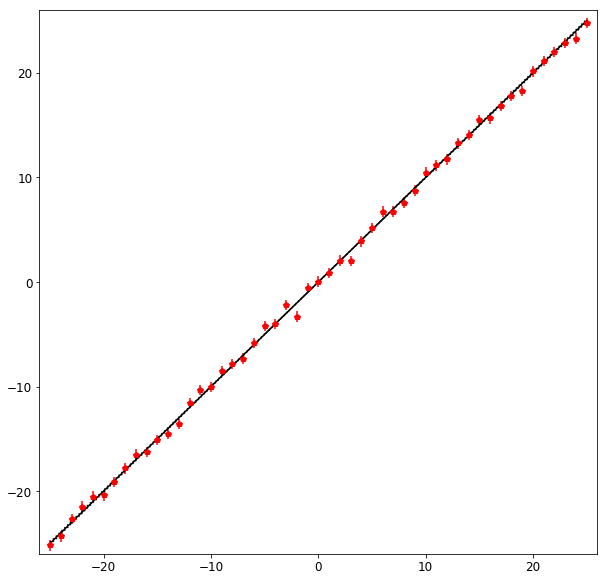

In [31]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((x_min-1, x_max+1))
ax.set_ylim((x_min-1, x_max+1))
plt.errorbar(SR_data_x,SR_data_y,yerr=SR_errors_y,color="r",ls='',marker="p")

x = np.linspace(x_min-1, x_max+1,100)
#plt.plot(x,trueYvsX(x),"k:")
plt.plot(SR_data_x,bkgModelFull_v2(SR_data_x,0),"k")
plt.plot(SR_data_x,bkgModelFull_v2(SR_data_x,-1),"k:")
plt.plot(SR_data_x,bkgModelFull_v2(SR_data_x,+1),"k:")


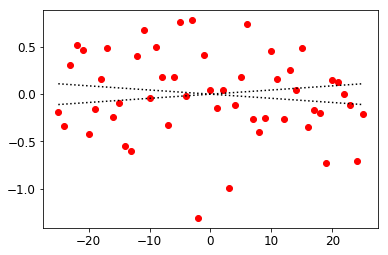

In [32]:
plt.plot(SR_data_x, SR_residuals,"ro")
plt.plot(SR_data_x,bkgModelFull_v2(SR_data_x,1)-bkgModelFull_v2(SR_data_x,0),"k:")
plt.plot(SR_data_x,bkgModelFull_v2(SR_data_x,-1)-bkgModelFull_v2(SR_data_x,0),"k:")

#plt.plot(SR_data_x,-1*slope_err,"k:")

In [33]:
p0 = [1]
fitResults = opt.curve_fit(bkgModelFull_v2, SR_data_x, SR_data_y, sigma=SR_errors_y, p0=p0)
p0_fit, p0_err = getFitParamAndError(fitResults,0)

In [34]:
print(p0_fit,p0_err)

-1.0505631081335567 0.9499186508776


## Now lets do it a bunch of times

In [35]:
p0_pulls = []

for i in range(10000):
    toy_data_x, toy_data_y, toy_errors_y = getData(sigmaY=y_err)
    p0 = [ 0]
    fitResults = opt.curve_fit(bkgModelFull_v2, toy_data_x, toy_data_y, sigma=toy_errors_y, p0=p0)
    p0_fit, p0_err = getFitParamAndError(fitResults,0)

    p0_pull = (p0_fit)/1
    p0_pulls.append(p0_pull)


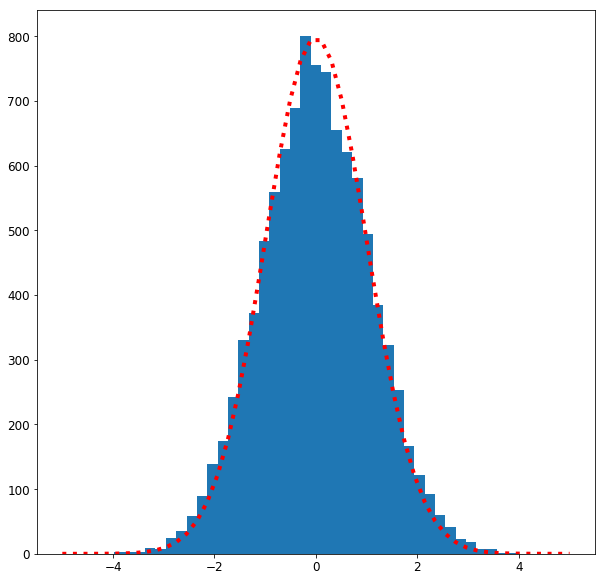

In [36]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.hist(p0_pulls,bins=np.linspace(-5,5,50))
x_axis = np.linspace(-5,5,50)

binWidth = 10/50
ax.plot(x_axis, 10000*binWidth*norm.pdf(x_axis,0,1),"r:",linewidth=4)
plt.show()

In [37]:
def getSysShiftedData_v2(p0,sigmaY=0.1,m=1,b=0):
    xs = np.linspace(x_min,x_max,nPoints)
    #ys = bkgModel(xs,m,b) + np.random.normal(0,sigmaY,len(xs))*bkgModel(xs)
    ys = bkgModelFull_v2(xs,p0) + np.random.normal(0,sigmaY,len(xs))
    eys = np.full(len(xs),sigmaY)
    return xs,ys,eys

In [38]:
p0_true = [] 
p0_sigma = 1
p0_fits = []
p0_pulls = []

for i in range(10000):
    p0_true.append(np.random.normal(0,1))
    toy_data_x, toy_data_y, toy_errors_y = getSysShiftedData_v2(p0_true[-1],sigmaY=y_err)
    p0 = [ 0]
    fitResults = opt.curve_fit(bkgModelFull_v2, toy_data_x, toy_data_y, sigma=toy_errors_y, p0=p0)
    p0_fit, p0_err = getFitParamAndError(fitResults,0)

    p0_fits.append(p0_fit)
    p0_pull = (p0_fit-p0_true[-1])/p0_sigma
    p0_pulls.append(p0_pull)



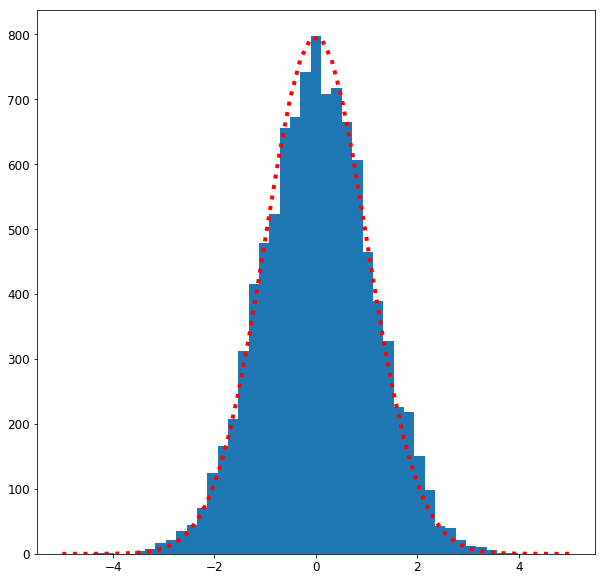

In [39]:
fig, ax = plt.subplots(1, figsize=(10,10))


ax.hist(p0_pulls,bins=np.linspace(-5,5,50))
x_axis = np.linspace(-5,5,50)

binWidth = 10/50
ax.plot(x_axis, 10000*binWidth*norm.pdf(x_axis,0,1),"r:",linewidth=4)
plt.show()

In [42]:
#fig, ax = plt.subplots(1, figsize=(10,10))
#ax.plot(p0_true,p0_fits,"ko")